In [1]:
import gym
import numpy as np

from ddpg import DDPG
from ou_noise import OUNoise
from replay_buffer import ReplayBuffer
from policynetwork import PolicyNetwork
from valuenetwork import ValueNetwork

import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

In [3]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [4]:
# env = NormalizedActions(gym.make("Pendulum-v0"))
from custom_cartpoleswingup import CartPoleSwingUpEnv
env = CartPoleSwingUpEnv()
ou_noise = OUNoise(env.action_space)

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)

ddpg = DDPG(policy_net, state_dim, action_dim, replay_buffer)

In [5]:
max_frames  = 12000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

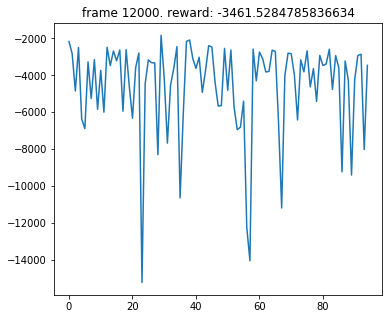

In [6]:
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg.update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        env.render()
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

In [9]:
state = env.reset()
episode_reward = 0

for step in range(max_steps):
    action = policy_net.get_action(state)
    next_state, reward, done, _ = env.step(action)

    state = next_state
    episode_reward += reward

    env.render()

    if done:
        break
    
